## **1: Exploring the Emotion Detection Dataset**

---
### **Loading the dataset**
We loaded the dataset by reading legend.csv to obtain the mapping between each image and its corresponding emotion label. Using this mapping, we iterated through the directory, opened each image, converted it to grayscale, resized it to 48×48 pixels, and stored the resulting arrays in X with their associated integer labels in Y.

In [1]:
# Necessary Imports
import os
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.decomposition import PCA


# Confirm Labels
legend = pd.read_csv("facial_expressions/data/legend.csv")
legend["emotion"] = legend["emotion"].str.lower().str.strip()
print(legend.head())

# Confirm Classes
classes = sorted(legend["emotion"].unique())
class_idx = {c:i for i,c in enumerate(classes)}
print("Emotion classes:", classes)                              # prints all possible labels

# Build X and Y
image_dir = "facial_expressions/images"
X = []
Y = []

for i, row in legend.iterrows():
    image = row["image"]
    emotion = row["emotion"]

    img_path = os.path.join(image_dir, image)

    img = Image.open(img_path).convert("L").resize((48, 48))    # load image, grayscale, resize to 48x48 pixels
    img_arr = np.array(img) / 255.0                             # normalize pixel values (scaling down)

    X.append(img_arr)                           
    Y.append(class_idx[emotion])

X = np.array(X)
Y = np.array(Y)

  user.id                            image   emotion
0     628  facial-expressions_2868588k.jpg     anger
1     628  facial-expressions_2868585k.jpg  surprise
2     628  facial-expressions_2868584k.jpg   disgust
3     628  facial-expressions_2868582k.jpg      fear
4   dwdii           Aaron_Eckhart_0001.jpg   neutral
Emotion classes: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


---
### **Exploration Summary**
We began by summarizing the characteristics of the facial expressions dataset. We measured the number of images per class, the image dimensions, and the channel structure. This allowed us to identify class imbalance and determine appropriate preprocessing choices.

**Shape of total images:** (13690, 48, 48)

**Shape of classes (emotions):** (13690,)

**Number of features:** 2304

Shape of feature vectors:  (13690, 48, 48)
Shape of labels:  (13690,)
Number of features:  2304
Number of examples:  13690


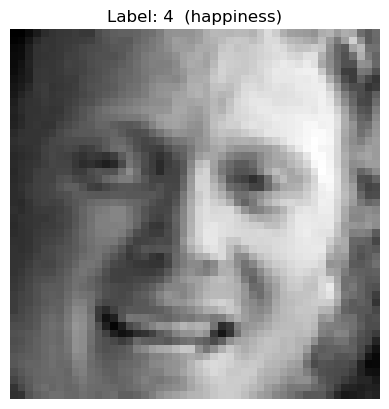

In [2]:
# Shape
print("Shape of feature vectors: ", X.shape)
print("Shape of labels: ", Y.shape)

print("Number of features: ", X.shape[1] * X.shape[2])
print("Number of examples: ", X.shape[0])

# Example Image and Label (after scaling and normalization)
plt.imshow(X[5], cmap="gray")
plt.title(f"Label: {Y[5]}  ({list(class_idx.keys())[list(class_idx.values()).index(Y[5])]})")
plt.axis("off")
plt.show()

#### **Class distribution** 

There is a significant imbalance regarding the number of samples for neutral and happy faces. This suggests that models may become biased toward predicting these majority classes, so stratified sampling and evaluation metrics beyond accuracy (like confusion matrices) are necessary.

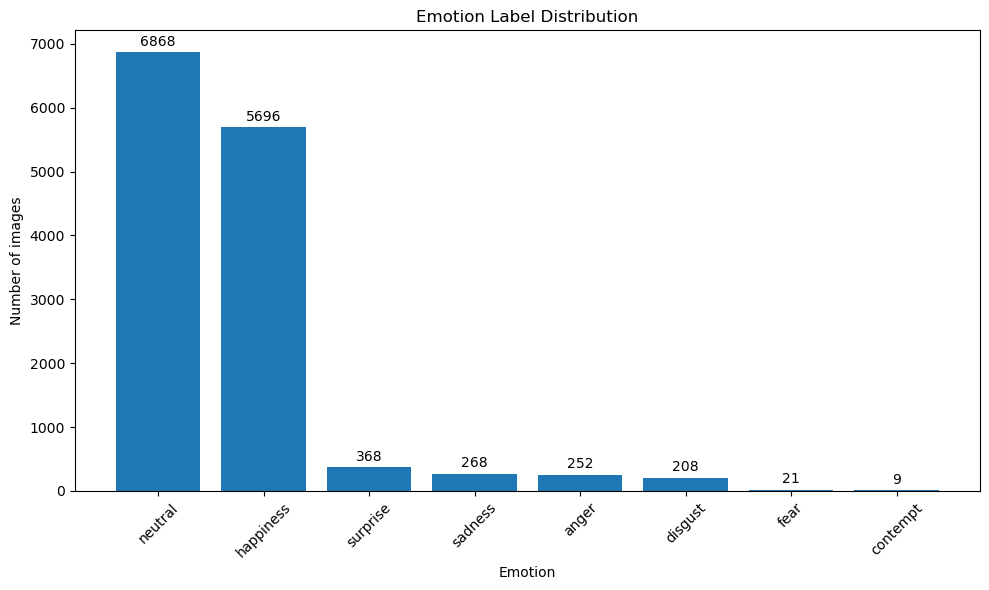

In [3]:
# Visualizing Class Distribution
counts = Counter(Y)
emotions = [c for c in classes]
values = [counts[class_idx[c]] for c in classes]

# Sort by count (descending)
sorted_pairs = sorted(zip(emotions, values), key=lambda x: x[1], reverse=True)
emotions_sorted, values_sorted = zip(*sorted_pairs)

plt.figure(figsize=(10, 6))
bars = plt.bar(emotions_sorted, values_sorted)

# Add count labels on top of each bar
for bar, val in zip(bars, values_sorted):
  plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
           str(val), ha='center', fontsize=10)

plt.xticks(rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Number of images")
plt.title("Emotion Label Distribution")
plt.tight_layout()
plt.show()

#### **Pixel Intensity** 

Histograms of pixel intensities at fixed image locations show significant variability across samples, even after normalization. This suggests that individual pixel features are noisy and insufficient on their own, motivating dimensionality reduction techniques such as PCA and models that can aggregate information across many pixels.

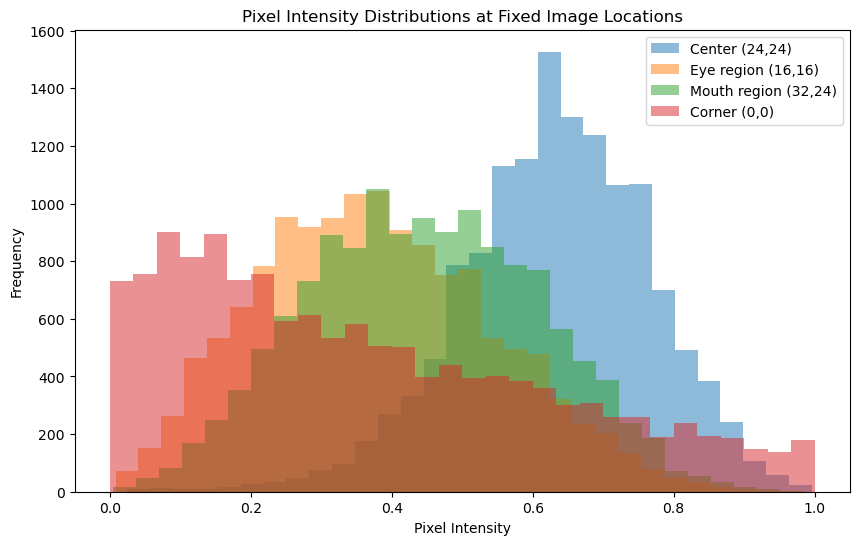

In [8]:
# Visualizing Pixel Distribution
pixel_locations = {
    "Center (24,24)": (24, 24),
    "Eye region (16,16)": (16, 16),
    "Mouth region (32,24)": (32, 24),
    "Corner (0,0)": (0, 0)
}

plt.figure(figsize=(10, 6))

for label, (r, c) in pixel_locations.items():
    values = X[:, r, c]
    plt.hist(values, bins=30, alpha=0.5, label=label)

plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distributions at Fixed Image Locations")
plt.legend()
plt.show()


#### **PCA Visualization**

Principle Component Analysis reduces each image to lower dimensions. Using PCA 2 allows us to visualize the 2 most important directions of variation in the images. This scatterplot shows that the data is not linearly separable by 2 dimensions, images are noisy, emotions visually overlap, and some expressions are subtle. Ultimately, this suggests that simple linear models (such as logistic regression or linear SVMs) are unlikely to perform well. The high overlap in PCA space also indicates that more complex nonlinear methods, such as SVMs with RBF kernels or convolutional neural networks, may be required to capture the structure of the data.

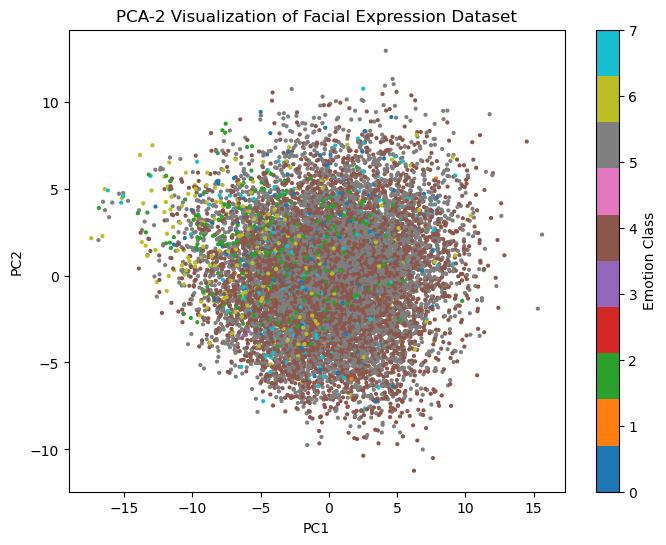

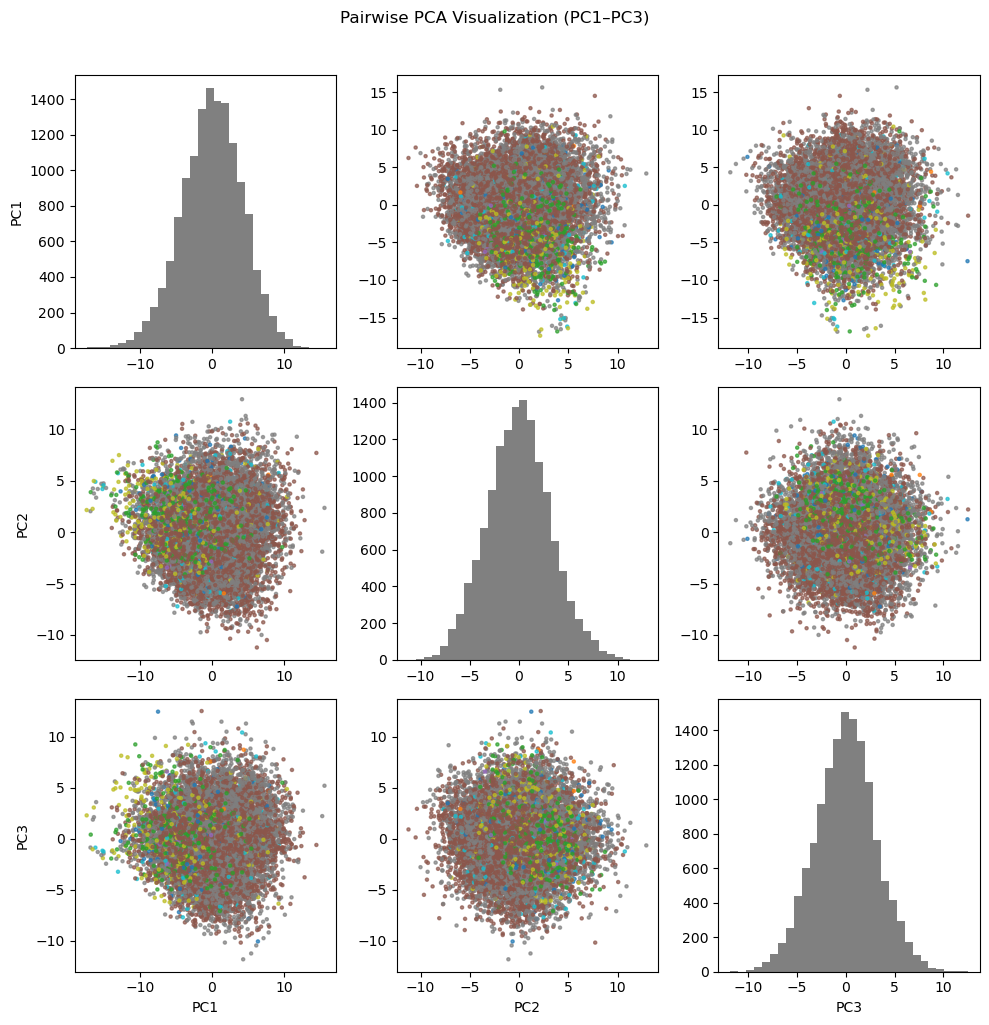

In [ ]:
# PCA Visualization

# PCA with 2 components
X_flat = X.reshape(X.shape[0], -1)
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_flat)

plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=Y, cmap="tab10", s=4)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA-2 Visualization of Facial Expression Dataset")
plt.colorbar(label="Emotion Class")
plt.show()

# PCA with 3 components
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_flat)

pcs = ["PC1", "PC2", "PC3"]
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]

        if i == j:
            ax.hist(X_pca3[:, i], bins=30, color="gray")
        else:
            ax.scatter(
                X_pca3[:, j],
                X_pca3[:, i],
                c=Y,
                cmap="tab10",
                s=5,
                alpha=0.7
            )

        if i == 2:
            ax.set_xlabel(pcs[j])
        if j == 0:
            ax.set_ylabel(pcs[i])

plt.suptitle("Pairwise PCA Visualization (PC1-PC3)", y=1.02)
plt.tight_layout()
plt.show()


## **2: Model Training & Evaluation**
---

We trained multiple classifiers to predict emotions and compared their performance.

In [ ]:
from model import run_models

classes = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

accuracies = run_models(X, Y, class_names=classes)

Data shapes: (13690, 2304) (13690,)

Baseline Model:
Most common emotion: 5
Baseline accuracy: 0.5018261504747992

Tuning Logistic Regression...
